### Experiments with topic modeling for Gregorian chant repertoire tradition detection
First some parameter selection  
1. Parameter search
    - CountVectorizer
    - max_df 
2. various number of topics for all data
3. various number of topics big feasts data only
4. two topic models and cursus
5. various number of topics union same provenances (with some additional restrictions) and treat them as documents

#### Common code

In [1]:
# Imports
import numpy as np
import pandas as pd

import lzma
import pickle

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

from collections import Counter, OrderedDict
from itertools import combinations

import matplotlib.pyplot as plt

In [2]:
# Read data
responsories_all = pd.read_csv('../data/all-ci-responsories.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('../data/all-ci-antiphons.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('../data/sources-with-provenance-ids-and-two-centuries.csv', usecols=['provenance_id', 'drupal_path', 'siglum', 'cursus', 'num_century'])
feasts = pd.read_csv('../data/feast.csv', usecols=['id', 'name'])

chants = pd.concat([responsories_all, antiphons_all])

In [3]:
# Construct dict to index sources
source_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    source_dict[id] = i
    i += 1

In [4]:
# Transform chant data into document like structure
source_all_chants_dict = {}
used_cantus_ids = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants['source_id'] == source_id
    used_cantus_ids += set((chants[filt_source]['cantus_id']).tolist())
    source_all_chants_dict[source_id] = ' '.join((chants[filt_source]['cantus_id']).tolist())

print("Number of chants in our sources", len(used_cantus_ids))
freq_CIDs = Counter(used_cantus_ids)
#print(freq_CIDs.most_common())
print('Number of CIDs used in our sources', len(set(used_cantus_ids)))

Number of chants in our sources 284579
Number of CIDs used in our sources 17599


In [5]:
def count_jaccard(community_variants, used_dict):
    ''' 
    Counts mean of Jaccard Index between all pairs from community varinats
    '''
    jaccard = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
    for pair in all_variants_pairs:
        friends_matrix = np.zeros([len(used_dict), len(used_dict)])
        for com_ver in pair:
            for com in com_ver:
                com = sorted(list(com))
                for s_pair in combinations(com, 2):
                    friends_matrix[used_dict[s_pair[0]], used_dict[s_pair[1]]] += 1
        unique, counts = np.unique(friends_matrix.flatten(), return_counts=True)
        try:
            twos = dict(zip(unique, counts))[2]
            sig_level = twos / np.count_nonzero(friends_matrix)
        except:
            sig_level = 0.0
        jaccard.append(sig_level)
    
    return (round(np.mean(jaccard), 2)) 

In [6]:
def count_rand(community_variants_labels):
    ''' 
    Counts mean of adjusted Rand Index between all pairs from community varinats
    '''
    rand = []
    all_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_pairs:
        rand.append(adjusted_rand_score(pair[0], pair[1]))
        
    return(np.mean(rand))

In [7]:
def count_mutual(community_variants_labels):
    ''' 
    Counts mean of adjusted Mutual information score between all pairs from community varinats
    '''
    mutual = []
    all_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_pairs:
        mutual.append(adjusted_mutual_info_score(pair[0], pair[1]))
        
    return(np.mean(mutual))

#### Choose CountVectorizer settings
Plot effect of max_df and min_df  
Create three options: smallest, less, all

In [8]:
# Get data to plot how maximal required document frequency affects number of CIDs while min_df fixed on extreme value
max_dfs = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 225, 250]
max_df_chants_dict = {}
for i in max_dfs:
    cv = CountVectorizer(max_df=i, min_df=0.0, token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
    cv_data = cv.fit_transform(source_all_chants_dict.values())
    max_df_chants_dict[i] = cv_data.shape[1]

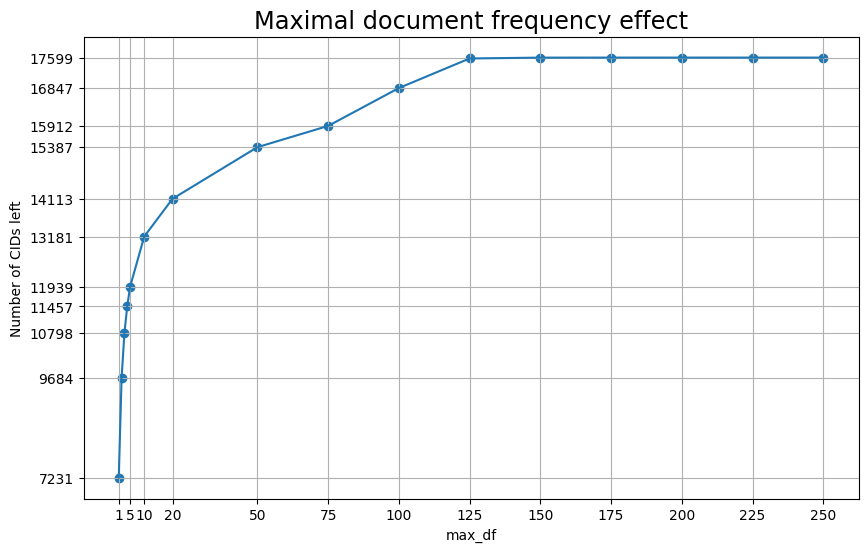

In [10]:
# Plot how maximal required document frequency affects number of CIDs while min_df fixed on extreme value
# Figure 4.8
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(x=max_df_chants_dict.keys(), y=max_df_chants_dict.values())
plt.plot(max_df_chants_dict.keys(), max_df_chants_dict.values())
plt.title("Maximal document frequency effect", fontsize='xx-large')
plt.xticks([1, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 225, 250])
plt.yticks(list(max_df_chants_dict.values())[:-6] + [list(max_df_chants_dict.values())[-1]])
plt.xlabel("max_df")
plt.ylabel("Number of CIDs left")
plt.show()

In [11]:
# Get dat to plot how minimal required document frequency affects number of CI while max_df fixed on extreme value
min_df_chants_dict = {}
for i in range(1, 21):
    cv = CountVectorizer(max_df=1.0, min_df=i, token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
    cv_data = cv.fit_transform(source_all_chants_dict.values())
    min_df_chants_dict[i] = cv_data.shape[1]

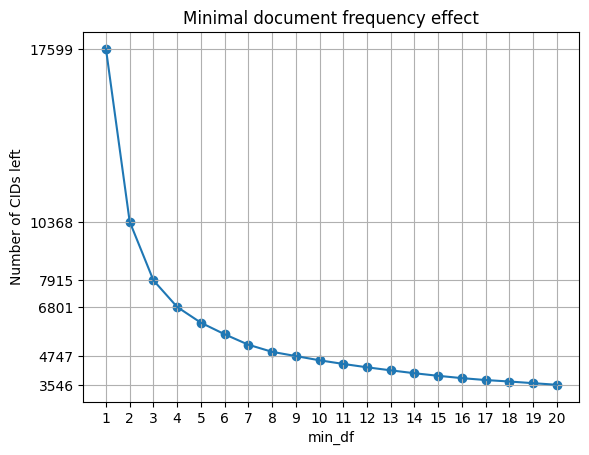

In [12]:
# Plot how minimal required document frequency affects number of CI while max_df fixed on extreme value
# figure 4.7
plt.scatter(x=min_df_chants_dict.keys(), y=min_df_chants_dict.values())
plt.plot(min_df_chants_dict.keys(), min_df_chants_dict.values())
plt.title("Minimal document frequency effect")
plt.xticks(list(min_df_chants_dict.keys()))
plt.xlabel("min_df")
plt.yticks(list(min_df_chants_dict.values())[:4] + [list(min_df_chants_dict.values())[8]] + [list(min_df_chants_dict.values())[-1]])
plt.ylabel("Number of CIDs left")
plt.grid()
plt.show()

##### Our three CountVectorizer possibilites

In [13]:
# Construct [sources x chants] matrix (document word matrix) for all data (all Cantus IDs)
all_count_vec = CountVectorizer(max_df=250, min_df=0.0, token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
all_count_vec_data = all_count_vec.fit_transform(source_all_chants_dict.values())
print("Most wide [sources x chants] matrix shape:", all_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - all_count_vec_data.shape[1], "CIDs")

Most wide [sources x chants] matrix shape: (250, 17599)
Loosing 0 CIDs


In [14]:
# Construct [sources x chants] matrix (document word matrix) for choosen data
# we use only words which are in 250 or less docs and also it at least two docs
less_count_vec = CountVectorizer(max_df=250, min_df=2, token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
less_count_vec_data = less_count_vec.fit_transform(source_all_chants_dict.values())
print("Less wide [sources x chants] matrix shape:", less_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - less_count_vec_data.shape[1], "CIDs")

Less wide [sources x chants] matrix shape: (250, 10368)
Loosing 7231 CIDs


In [15]:
# Construct [sources x chants] matrix (document word matrix) for choosen data
# we use only words which are in 250 or less docs and also it at least eight docs
smallest_count_vec = CountVectorizer(max_df=250, min_df=8, token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
smallest_count_vec_data = smallest_count_vec.fit_transform(source_all_chants_dict.values())
print("The least wide [sources x chants] matrix shape:", smallest_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - smallest_count_vec_data.shape[1], "CIDs")

The least wide [sources x chants] matrix shape: (250, 4924)
Loosing 12675 CIDs


### Parameters search
Parameters:
- max_iter  
- CountVectorizer

In [16]:
# Options to be tested
num_of_topics_params = [2, 5, 10, 20]

max_iter_options = [10, 20, 30, 40, 50]

cv_options = [all_count_vec, less_count_vec, smallest_count_vec]
cv_opt_string = ["all_count_vec", "less_count_vec", "smallest_count_vec"]

random_states = [i for i in range(42, 450)]

In [69]:
params_dict = {}

In [ ]:
# Collect behaviour of models on diffrent parameters settings
num_of_runs_params = 10
for t in num_of_topics_params:
    params_topic_dict = {}
    for iter in max_iter_options:
        cv_index = 0
        for cv in cv_options:
            print((iter, cv_opt_string[cv_index]))
            community_variants = []
            community_variants_labels = []
            for i in range(num_of_runs_params):
                model = LatentDirichletAllocation(n_components=t, max_iter=iter, evaluate_every=5, random_state=random_states[i])
                data_trans = cv.fit_transform([source_all_chants_dict[s] for s in sources['drupal_path'].tolist()])
                result = model.fit_transform(data_trans)
                topics = result.argmax(axis=1)

                community_variants_labels.append(topics)

                restored_comm = {}
                for topic in range(t):
                    restored_comm[topic] = []

                for n in range(len(topics)):
                    restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

                community_variants.append(list(restored_comm.values()))

            params_topic_dict[(iter, cv_opt_string[cv_index])] = {'names' : community_variants, 'labels' : community_variants_labels}
            cv_index += 1

    params_dict[t] = params_topic_dict

In [17]:
#with lzma.open("saved_results/topic_modeling/params_dict.txt", "rb") as model_file:
#    params_dict = pickle.load(model_file)

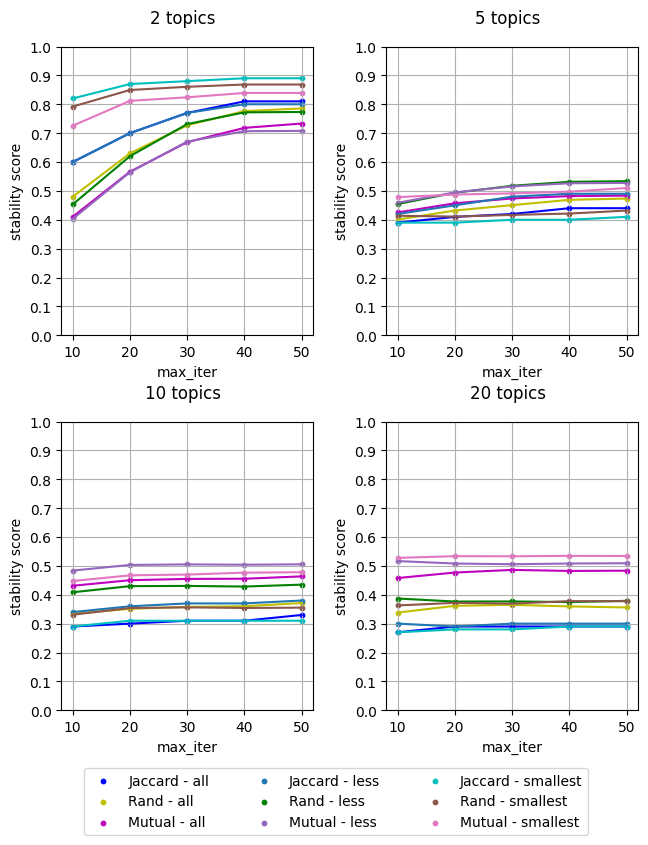

In [24]:
# Plot stability score based on parameters changes
# One plot for each number of topics
# Figure 4.9
cv_opt_string_plot = ['all', 'less', 'smallest']
colors = ['b', 'y', 'm', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:orange', 'r']
labels = ['Jaccard', 'Rand', 'Mutual']
fig = plt.figure()
fig.set_figwidth(6.5)
fig.set_figheight(7.5)
subfigs = fig.subfigures(2, 2)
for t, subfig in zip(num_of_topics_params, subfigs.flat):
    data = params_dict[t]
    ax1 = subfig.add_subplot(111)
    x = max_iter_options
    color_index = 0
    cv_index = 0
    for cv in cv_opt_string:
        y = []
        for iter in max_iter_options:
            y.append((count_jaccard(data[(iter, cv)]['names'], source_dict), 
                        count_rand(data[(iter, cv)]['labels']), 
                        count_mutual(data[(iter, cv)]['labels'])))
        for i in range(3):
            ax1.scatter(x=x, y=[iter_var[i] for iter_var in y], s=10, marker='o', label=labels[i]+" - "+cv_opt_string_plot[cv_index], color=colors[i+color_index])
            ax1.plot(x, [iter_var[i] for iter_var in y], color=colors[i+color_index])
        color_index += 3
        cv_index += 1

    plt.grid()
    subfig.suptitle(str(t) + ' topics')
    ax1.set_xticks(x)
    ax1.set_xlabel('max_iter')
    ax1.set_ylabel('stability score')
    ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.legend(bbox_to_anchor=(-1.2, -0.6, 2.0, 0.4), ncols=3, mode="expand", borderaxespad=0.)
# plt.suptitle('Parameters search - 10 runs on each configuration', fontsize='xx-large')
plt.show()

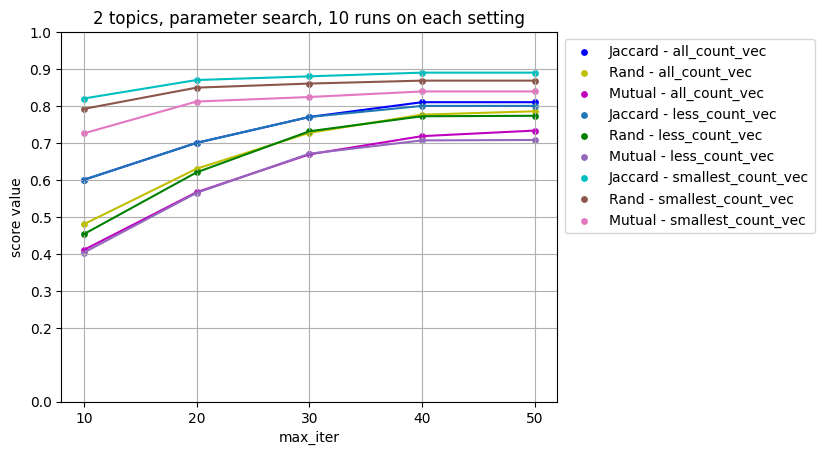

In [100]:
# 2 topics
data2 = params_dict[2]
colors = ['b', 'y', 'm', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:orange', 'r']
labels = ['Jaccard', 'Rand', 'Mutual']
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = max_iter_options
color_index=0
for cv in cv_opt_string:
    y = []
    for iter in max_iter_options:
        y.append((count_jaccard(data2[(iter, cv)]['names'], source_dict), 
                    count_rand(data2[(iter, cv)]['labels']), 
                    count_mutual(data2[(iter, cv)]['labels'])))
    for i in range(3):
        ax1.scatter(x=x, y=[iter_var[i] for iter_var in y], s=15, marker='o', label=labels[i]+" - "+cv, color=colors[i+color_index])
        ax1.plot(x, [iter_var[i] for iter_var in y], color=colors[i+color_index])
    color_index += 3

plt.grid()
plt.title('2 topics, parameter search, 10 runs on each setting')
plt.xticks(x)
plt.xlabel('max_iter')
plt.ylabel('score value')
plt.yticks([0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.legend(bbox_to_anchor=(1.001, 1.0))

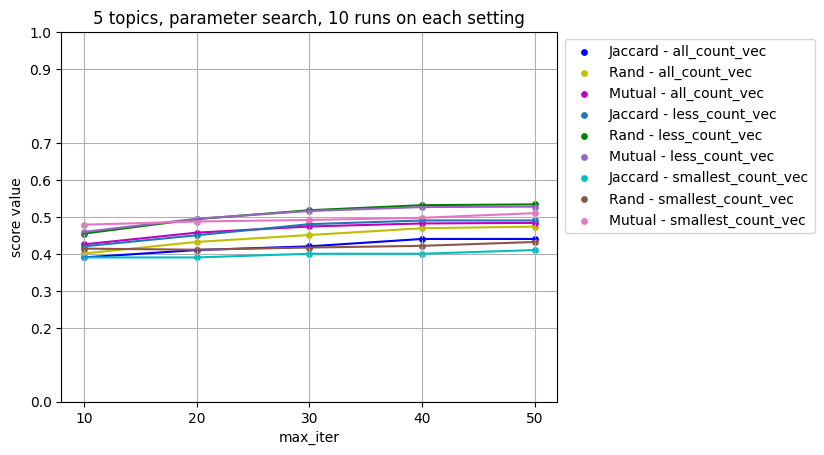

In [92]:
# 5 topics
data5 = params_dict[5]
colors = ['b', 'y', 'm', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:orange', 'r']
labels = ['Jaccard', 'Rand', 'Mutual']
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = max_iter_options
color_index=0
for cv in cv_opt_string:
    y = []
    for iter in max_iter_options:
        y.append((count_jaccard(data5[(iter, cv)]['names'], source_dict), 
                    count_rand(data5[(iter, cv)]['labels']), 
                    count_mutual(data5[(iter, cv)]['labels'])))
    for i in range(3):
        ax1.scatter(x=x, y=[iter_var[i] for iter_var in y], s=15, marker='o', label=labels[i]+" - "+cv, color=colors[i+color_index])
        ax1.plot(x, [iter_var[i] for iter_var in y], color=colors[i+color_index])
    color_index += 3

plt.grid()
plt.title('5 topics, parameter search, 10 runs on each setting')
plt.xticks(x)
plt.xlabel('max_iter')
plt.ylabel('score value')
plt.yticks([0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0])
plt.legend(bbox_to_anchor=(1.001, 1.0))

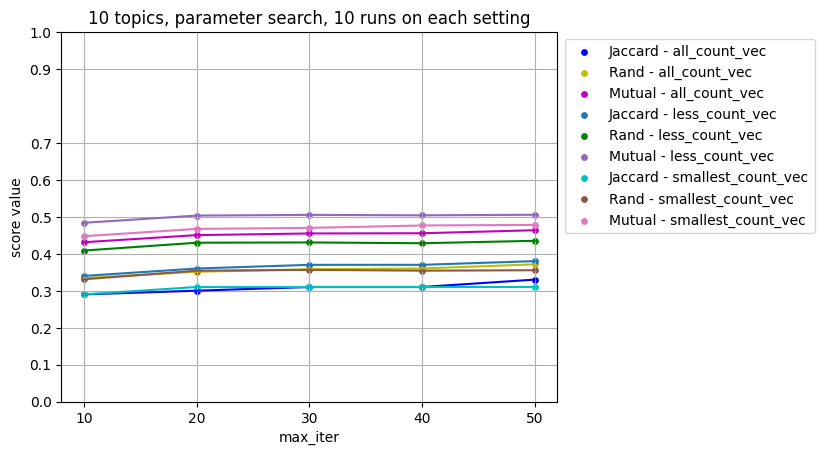

In [102]:
# 10 topics
data10 = params_dict[10]
colors = ['b', 'y', 'm', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:orange', 'r']
labels = ['Jaccard', 'Rand', 'Mutual']
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = max_iter_options
color_index=0
for cv in cv_opt_string:
    y = []
    for iter in max_iter_options:
        y.append((count_jaccard(data10[(iter, cv)]['names'], source_dict), 
                    count_rand(data10[(iter, cv)]['labels']), 
                    count_mutual(data10[(iter, cv)]['labels'])))
    for i in range(3):
        ax1.scatter(x=x, y=[iter_var[i] for iter_var in y], s=15, marker='o', label=labels[i]+" - "+cv, color=colors[i+color_index])
        ax1.plot(x, [iter_var[i] for iter_var in y], color=colors[i+color_index])
    color_index += 3

plt.grid()
plt.title('10 topics, parameter search, 10 runs on each setting')
plt.xticks(x)
plt.xlabel('max_iter')
plt.ylabel('score value')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0])
plt.legend(bbox_to_anchor=(1.001, 1.0))

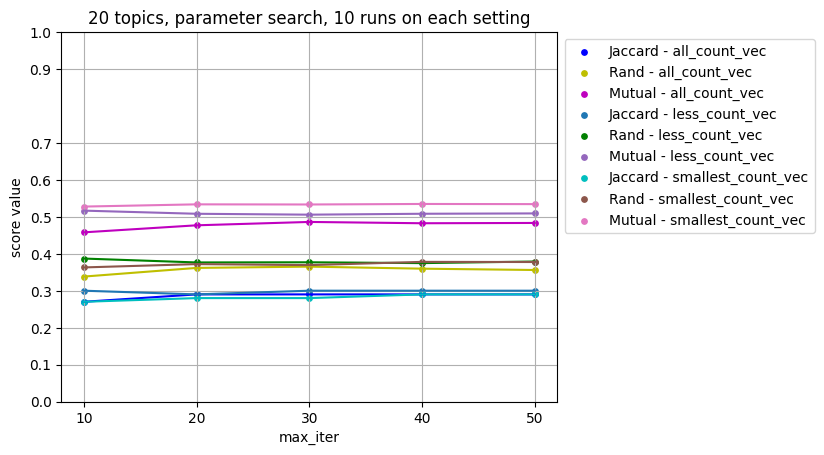

In [18]:
# 20 topics
data20 = params_dict[20]
colors = ['b', 'y', 'm', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:orange', 'r']
labels = ['Jaccard', 'Rand', 'Mutual']
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = max_iter_options
color_index=0
for cv in cv_opt_string:
    y = []
    for iter in max_iter_options:
        y.append((count_jaccard(data20[(iter, cv)]['names'], source_dict), 
                    count_rand(data20[(iter, cv)]['labels']), 
                    count_mutual(data20[(iter, cv)]['labels'])))
    for i in range(3):
        ax1.scatter(x=x, y=[iter_var[i] for iter_var in y], s=15, marker='o', label=labels[i]+" - "+cv, color=colors[i+color_index])
        ax1.plot(x, [iter_var[i] for iter_var in y], color=colors[i+color_index])
    color_index += 3

plt.grid()
plt.title('20 topics, parameter search, 10 runs on each setting')
plt.xticks(x)
plt.xlabel('max_iter')
plt.ylabel('score value')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0])
plt.legend(bbox_to_anchor=(1.001, 1.0))

##### Not included in thesis text
Just to be sure we did not miss anything insteresting, lets work more with max_df and look how it affects stability on four basic number_of_topics options.

In [ ]:
# Construct [sources x chants] matrix (document word matrix) for choosen data
# we use only words which are in 250 or less docs and also it at least eight docs
maxDf_count_vec = CountVectorizer(max_df=50, min_df=5, token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
maxDf_count_vec_data = maxDf_count_vec.fit_transform(source_all_chants_dict.values())
print("The least wide [sources x chants] matrix shape:", maxDf_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - maxDf_count_vec_data.shape[1], "CIDs")

In [36]:
maxDf_dict = {}

In [45]:
num_of_topics_maxDf = [20] # 2, 5, 10, 20]

for t in num_of_topics_maxDf:
    community_variants = []
    community_variants_labels = []
    for i in range(20):
        model = LatentDirichletAllocation(n_components=t, max_iter=40, evaluate_every=5, random_state=random_states[i])
        data_trans = maxDf_count_vec.fit_transform([source_all_chants_dict[s] for s in sources['drupal_path'].tolist()])
        result = model.fit_transform(data_trans)
        topics = result.argmax(axis=1)

        community_variants_labels.append(topics)

        restored_comm = {}
        for topic in range(t):
            restored_comm[topic] = []

        for n in range(len(topics)):
            restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

        community_variants.append(list(restored_comm.values()))

    maxDf_dict[t] = {'names' : community_variants, 'labels' : community_variants_labels}
    

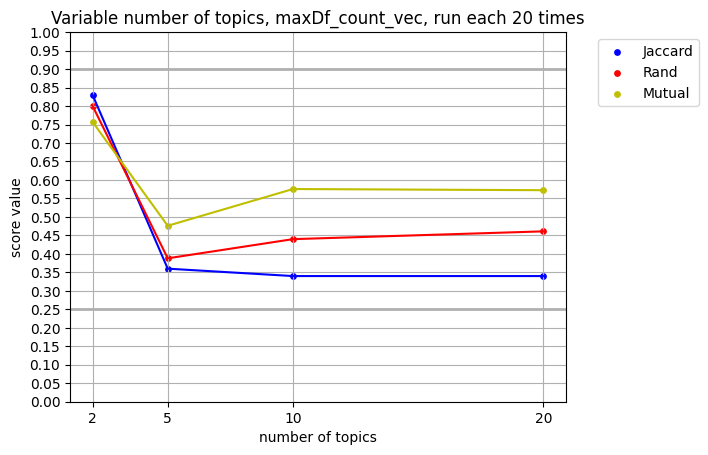

In [46]:
num_of_topics_maxDf = [2, 5, 10, 20]
fig = plt.figure()
ax1 = fig.add_subplot(111)

yj = [count_jaccard(x['names'], source_dict) for x in list(maxDf_dict.values())]
ax1.scatter(x=num_of_topics_maxDf, y=yj, s=15, c='b', marker="o", label='Jaccard')
ax1.plot(num_of_topics_maxDf, yj, c='b')

yr = [count_rand(x['labels']) for x in list(maxDf_dict.values())]
ax1.scatter(x=num_of_topics_maxDf, y=yr, s=15, c='r', marker="o", label='Rand')
ax1.plot(num_of_topics_maxDf, yr, c='r')

ym = [count_mutual(x['labels']) for x in list(maxDf_dict.values())]
ax1.scatter(x=num_of_topics_maxDf, y=ym, s=15, c='y', marker="o", label='Mutual')
ax1.plot(num_of_topics_maxDf, ym, c='y')

plt.xlabel("number of topics")
plt.xticks(num_of_topics_maxDf)
plt.ylabel("score value")
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics, maxDf_count_vec, run each 20 times") #, max_iter = 40, evaluate every 1 and specific CV - not all
plt.grid()
gridlines = ax1.get_ygridlines()
up = gridlines[18]
down = gridlines[5]
up.set_linewidth(2)
down.set_linewidth(2)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Topic number options on "best setting" - stability eval
evaluate_every = 1  
max_iter = 40  
CountVectorizer -> based on parameter searcvh result  
- for 2, 3, 4 it is smallest_count_vec
- for higher it is less_count_vec  
  
number of runs = 15

In [20]:
# Options and random satates
num_of_topics_all_t = [2, 3, 4, 5, 6 , 7, 8, 9, 10, 12, 15, 17, 20]
max_iter_all_t = 40

random_states = [i for i in range(42, 450)]

In [ ]:
cv_data_all_t = {2 : smallest_count_vec_data, 3 : smallest_count_vec_data, 4 : smallest_count_vec_data}
for t in num_of_topics_all_t[3:]:
    cv_data_all_t[t] = less_count_vec_data

In [18]:
dict_all_topics = {}

In [ ]:
# Construct 15 models for each number of topics
# Store community results for stability eval
num_of_runs_t = 15
for t in num_of_topics_all_t:
    print("topic", t)
    community_variants = []
    community_variants_labels = []
    for i in range(num_of_runs_t):
        model = LatentDirichletAllocation(n_components=t, max_iter=max_iter_all_t, evaluate_every=1, random_state=random_states[i])
        data_trans = cv_data_all_t[t]
        result = model.fit_transform(data_trans)
        topics = result.argmax(axis=1)

        community_variants_labels.append(topics)

        restored_comm = {}
        for topic in range(t):
            restored_comm[topic] = []

        for n in range(len(topics)):
            restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

        community_variants.append(list(restored_comm.values()))
    dict_all_topics[t] = {'names' : community_variants, 'labels' : community_variants_labels}

In [26]:
#with lzma.open("saved_results/topic_modeling/dict_all_topics.txt", "rb") as model_file:
#    dict_all_topics = pickle.load(model_file)

In [25]:
# Print out stability score results
for t in dict_all_topics.keys():
    print("Number of topics:", t)
    print("  max_iter =", 40)
    #print("  CountVectorizer:", cv_data_all_t[])
    print("\t Jaccard index:", count_jaccard(dict_all_topics[t]['names'], source_dict))
    print("\t Rand index:", count_rand(dict_all_topics[t]['labels']))
    print("\t Mutual info score:", count_mutual(dict_all_topics[t]['labels']))
    print()

Number of topics: 2
  max_iter = 40
	 Jaccard index: 0.87
	 Rand index: 0.8493708474101093
	 Mutual info score: 0.8158133963775869

Number of topics: 3
  max_iter = 40
	 Jaccard index: 0.69
	 Rand index: 0.693926105279071
	 Mutual info score: 0.6792995715114054

Number of topics: 4
  max_iter = 40
	 Jaccard index: 0.52
	 Rand index: 0.5356976511484689
	 Mutual info score: 0.5493667389006323

Number of topics: 5
  max_iter = 40
	 Jaccard index: 0.46
	 Rand index: 0.49347064585961387
	 Mutual info score: 0.5005289964990408

Number of topics: 6
  max_iter = 40
	 Jaccard index: 0.46
	 Rand index: 0.5085187860807838
	 Mutual info score: 0.5115913144663127

Number of topics: 7
  max_iter = 40
	 Jaccard index: 0.41
	 Rand index: 0.46434143367417496
	 Mutual info score: 0.5039035514823026

Number of topics: 8
  max_iter = 40
	 Jaccard index: 0.43
	 Rand index: 0.49119717338557045
	 Mutual info score: 0.5236796469914657

Number of topics: 9
  max_iter = 40
	 Jaccard index: 0.42
	 Rand index: 0.

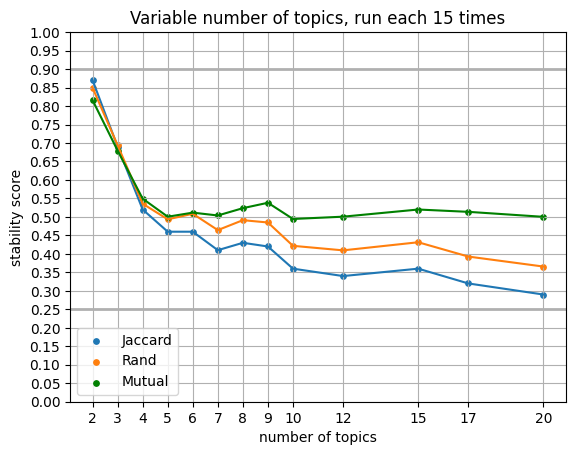

In [27]:
# Plot results 
num_of_topics_all_t = [2, 3, 4, 5, 6 , 7, 8, 9, 10, 12, 15, 17, 20]
fig = plt.figure()
ax1 = fig.add_subplot(111)

yj = [count_jaccard(x['names'], source_dict) for x in list(dict_all_topics.values())]
ax1.scatter(x=num_of_topics_all_t, y=yj, s=15, c='tab:blue', marker="o", label='Jaccard')
ax1.plot(num_of_topics_all_t, yj, c='tab:blue')

yr = [count_rand(x['labels']) for x in list(dict_all_topics.values())]
ax1.scatter(x=num_of_topics_all_t, y=yr, s=15, c='tab:orange', marker="o", label='Rand')
ax1.plot(num_of_topics_all_t, yr, c='tab:orange')

ym = [count_mutual(x['labels']) for x in list(dict_all_topics.values())]
ax1.scatter(x=num_of_topics_all_t, y=ym, s=15, c='g', marker="o", label='Mutual')
ax1.plot(num_of_topics_all_t, ym, c='g')

plt.xlabel("number of topics")
plt.xticks(num_of_topics_all_t)
plt.ylabel("stability score")
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics, run each 15 times") #, max_iter = 40, evaluate every 1 and specific CV - not all
plt.grid()
gridlines = ax1.get_ygridlines()
up = gridlines[18]
down = gridlines[5]
up.set_linewidth(2)
down.set_linewidth(2)
plt.legend(loc='lower left')
plt.show()

### Big feasts
Take 10 biggests feasts and construct documnets from their data (and their sources)

In [28]:
# Get 10 feasts with most data
biggest_feasts = chants['feast_id'].value_counts()[:10].keys()

for feast_id in biggest_feasts.tolist():
    print(feasts[feasts['id'] == feast_id]['name'].values[0])

Nativitas Domini
Purificatio Mariae
Epiphania
Assumptio Mariae
Comm. Apostolorum
Comm. plurimorum Martyrum
Omnium Sanctorum
Fer. 5 in Cena Dom.
Dom. in Palmis
Joannis Baptistae


In [29]:
# Get sources where all 10 big feasts are present
all_big_f_sources = []
for source_id in sources['drupal_path'].tolist():
    if len(set(biggest_feasts.tolist()).intersection(set(chants[chants['source_id'] == source_id]['feast_id'].tolist()))) == 10:
        all_big_f_sources.append(source_id)

print('Number of sources containing all our biggest feasts:', len(all_big_f_sources))

Number of sources containing all our biggest feasts: 51


In [38]:
# Create dictionary to index this 51 sources
big_f_source_dict = OrderedDict()
i = 0
for id in source_chants_dict_big_f.keys():
    big_f_source_dict[id] = i
    i += 1

In [30]:
# Construct documents structure for those 10 feasts and 51 sources
source_chants_dict_big_f = {}
used_cantus_ids_big_f = []
for source_id in all_big_f_sources:
    filt_source = chants['source_id'] == source_id
    source_chants = chants[filt_source]
    if (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist() != []:
        used_cantus_ids_big_f += (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist()
        source_chants_dict_big_f[source_id] = ' '.join(source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id'].tolist())

print('Number of cantus_ids used in our sources:', len(set(used_cantus_ids_big_f)))
print('Number of sources containing all our biggest feasts:', len(source_chants_dict_big_f))

Number of cantus_ids used in our sources: 1293
Number of sources containing all our biggest feasts: 51


In [31]:
# Tested number of topics options
big_f_topics = [2, 3, 4, 5, 7, 10, 15, 20]

In [43]:
dict_big_f = {}

In [ ]:
# Run 15 times and store communities
count_vec_big_f = CountVectorizer(max_df=1.0, min_df=0.0, token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
trans_data_big_f = count_vec_big_f.fit_transform(source_chants_dict_big_f.values())

num_of_runs_big_f = 15
for t in big_f_topics:
    print(t)
    community_variants = []
    community_variants_labels = []
    for i in range(num_of_runs_big_f):
        model = LatentDirichletAllocation(n_components=t, max_iter=40, evaluate_every=1, random_state=random_states[i])
        result = model.fit_transform(trans_data_big_f)
        topics = result.argmax(axis=1)

        community_variants_labels.append(topics)

        restored_comm = {}
        for topic in range(t):
            restored_comm[topic] = []

        for n in range(len(topics)):
            restored_comm[topics[n]].append(list(source_chants_dict_big_f.keys())[n])

        community_variants.append(list(restored_comm.values()))

    dict_big_f[t] = {'names' : community_variants, 'labels' : community_variants_labels}

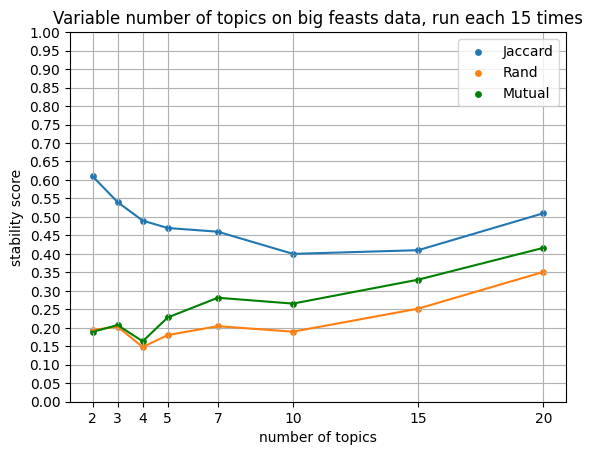

In [46]:
# Plot result of big feasts data
fig = plt.figure()
ax1 = fig.add_subplot(111)

yj = [count_jaccard(x['names'], big_f_source_dict) for x in list(dict_big_f.values())]
ax1.scatter(x=big_f_topics, y=yj, s=15, c='tab:blue', marker="o", label='Jaccard')
ax1.plot(big_f_topics, yj, c='tab:blue')

yr = [count_rand(x['labels']) for x in list(dict_big_f.values())]
ax1.scatter(x=big_f_topics, y=yr, s=15, c='tab:orange', marker="o", label='Rand')
ax1.plot(big_f_topics, yr, c='tab:orange')

ym = [count_mutual(x['labels']) for x in list(dict_big_f.values())]
ax1.scatter(x=big_f_topics, y=ym, s=15, c='g', marker="o", label='Mutual')
ax1.plot(big_f_topics, ym, c='g')

plt.xlabel("number of topics")
plt.xticks(big_f_topics)
plt.ylabel("stability score")
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics on big feasts data, run each 15 times") #own complete CV
plt.grid()
plt.legend(loc='upper right')
plt.show()

### Two topics and cursus?
Try to build two topic models (on different CV) and examine if their split is possibly based on cursus

In [48]:
# Construct two-topic models on all CV options and 
num_of_runs_cursus = 10
cursus_dict = {}
cv_data = [all_count_vec_data, less_count_vec_data, smallest_count_vec_data]
two_topic_coms = {}

j = 0
for cv in cv_options:
    cursus_dict[cv_opt_string[j]] = {}
    community_variants = []
    two_topic_coms[j] = []
    for i in range(num_of_runs_cursus):
        model = LatentDirichletAllocation(n_components=2, max_iter=30, evaluate_every=1, random_state=random_states[i])
        result = model.fit_transform(cv_data[j])
        topics = result.argmax(axis=1)

        restored_comm = {}
        for topic in range(2):
            restored_comm[topic] = []

        for n in range(len(topics)):
            restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])
        
        two_topic_coms[j].append(restored_comm)

        cursus_dict[cv_opt_string[j]][i] = {'Rom' : [], 'nonRom' : []}
        if len(Counter([sources[sources['drupal_path'] == s_id]['cursus'].values[0] for s_id in list(restored_comm.values())[0]])) == 4:
            cursus_dict[cv_opt_string[j]][i]['Rom'] = Counter([sources[sources['drupal_path'] == s_id]['cursus'].values[0] for s_id in list(restored_comm.values())[0]])
            cursus_dict[cv_opt_string[j]][i]['nonRom'] = Counter([sources[sources['drupal_path'] == s_id]['cursus'].values[0] for s_id in list(restored_comm.values())[1]])
        else:
            cursus_dict[cv_opt_string[j]][i]['Rom'] = Counter([sources[sources['drupal_path'] == s_id]['cursus'].values[0] for s_id in list(restored_comm.values())[1]])
            cursus_dict[cv_opt_string[j]][i]['nonRom'] = Counter([sources[sources['drupal_path'] == s_id]['cursus'].values[0] for s_id in list(restored_comm.values())[0]])

    j += 1

In [59]:
# Explore counted two topics
for j in [2]: #range(len(cv_opt_string)):
    print(cv_opt_string[j])
    for i in range(num_of_runs_cursus):
        print(cursus_dict[cv_opt_string[j]][i])

smallest_count_vec
{'Rom': Counter({'Secular': 51, 'Unknown': 34, 'Monastic': 12, 'Romanum': 3}), 'nonRom': Counter({'Secular': 60, 'Unknown': 52, 'Monastic': 38})}
{'Rom': Counter({'Secular': 51, 'Unknown': 34, 'Monastic': 12, 'Romanum': 3}), 'nonRom': Counter({'Secular': 60, 'Unknown': 52, 'Monastic': 38})}
{'Rom': Counter({'Unknown': 51, 'Secular': 50, 'Monastic': 13, 'Romanum': 3}), 'nonRom': Counter({'Secular': 61, 'Monastic': 37, 'Unknown': 35})}
{'Rom': Counter({'Secular': 51, 'Unknown': 34, 'Monastic': 12, 'Romanum': 3}), 'nonRom': Counter({'Secular': 60, 'Unknown': 52, 'Monastic': 38})}
{'Rom': Counter({'Secular': 51, 'Unknown': 34, 'Monastic': 12, 'Romanum': 3}), 'nonRom': Counter({'Secular': 60, 'Unknown': 52, 'Monastic': 38})}
{'Rom': Counter({'Secular': 51, 'Unknown': 51, 'Monastic': 13, 'Romanum': 3}), 'nonRom': Counter({'Secular': 60, 'Monastic': 37, 'Unknown': 35})}
{'Rom': Counter({'Secular': 51, 'Unknown': 34, 'Monastic': 12, 'Romanum': 3}), 'nonRom': Counter({'Secula

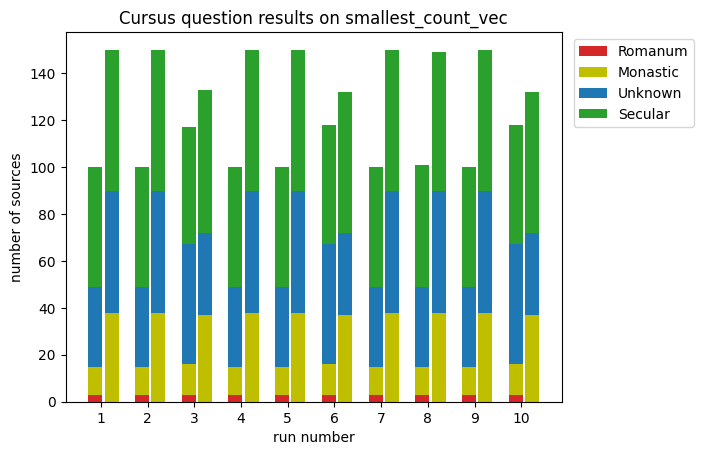

In [61]:
# Plot it behavior on smallest_count_vec
exp_num = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
colors = {'Romanum' : 'tab:red', 'Monastic' : 'y', 'Secular' : 'tab:green', 'Unknown' : 'tab:blue'}

weight_counts_Rom = {
    "Romanum" : [],
    "Monastic" : [],
    "Unknown" : [],
    "Secular" : []
}

weight_counts_nonRom = {
    "Romanum" : [],
    "Monastic" : [],
    "Unknown" : [],
    "Secular" : []
}
for i in range(num_of_runs_cursus):
    for com in cursus_dict[cv_opt_string[2]][i]['Rom']:
        weight_counts_Rom[com].append(cursus_dict[cv_opt_string[2]][i]['Rom'][com])
    for com in cursus_dict[cv_opt_string[2]][i]['nonRom']:
        weight_counts_nonRom[com].append(cursus_dict[cv_opt_string[2]][i]['nonRom'][com])
    weight_counts_nonRom['Romanum'].append(0)


width = 0.3
x = np.arange(len(exp_num))

fig, ax = plt.subplots()
bottom = np.zeros(10)

for cursus, weight_count in weight_counts_Rom.items():
    p = ax.bar(exp_num, weight_count, width, label=cursus, bottom=bottom, color=colors[cursus])
    bottom += weight_count

bottom = np.zeros(10)
offset = 0.35
for cursus, weight_count in weight_counts_nonRom.items():
    p = ax.bar(x+offset, weight_count, width, color=colors[cursus], bottom=bottom)
    bottom += weight_count

plt.xticks(x + 0.12, exp_num)
plt.title("Cursus question results on smallest_count_vec")
plt.xlabel("run number")
plt.ylabel("number of sources")
plt.legend(bbox_to_anchor=(1.01, 1.0))

plt.show()

In [49]:
# Lets have a look on the two versions and chcek for czech sources behaviour
# on smallest_count_vec
one = two_topic_coms[2][0]
two = two_topic_coms[2][2]

six_czech_sources = {"http://cantusbohemiae.cz/source/33177" : "CZ-Pn XII A 24", 
                      "http://cantusbohemiae.cz/source/4478" : "CZ-Pu Pu XIV A 19", 
                      "http://cantusbohemiae.cz/source/28509" : "CZ-Pn XV A 10",
                      "http://cantusdatabase.org/source/123730" : "CZ-Pu XIV B 13", 
                      "http://cantusdatabase.org/source/123727" : "CZ-Pu VI.E.4c", 
                      "http://cantusbohemiae.cz/source/28488" : "CZ-Pu VI G 11"}

print('first version')
for comm in one:
    print(comm)
    for source_id in one[comm]:
        if source_id in six_czech_sources.keys():
            print(six_czech_sources[source_id])

print('\nsecond version')
for comm in two:
    print(comm)
    for source_id in two[comm]:
        if source_id in six_czech_sources.keys():
            print(six_czech_sources[source_id])

first version
0
CZ-Pu VI.E.4c
CZ-Pu XIV B 13
CZ-Pu Pu XIV A 19
CZ-Pn XV A 10
CZ-Pn XII A 24
1
CZ-Pu VI G 11

second version
0
CZ-Pu VI G 11
1
CZ-Pu VI.E.4c
CZ-Pu XIV B 13
CZ-Pu Pu XIV A 19
CZ-Pn XV A 10
CZ-Pn XII A 24


### Provenance union
Implementing the idea of merging content of books from one place, time and century

In [69]:
# Provenance union data collecting - consider also century and cursus
sources['provenance_id'] = sources['provenance_id'].fillna('unknown')
prov_source_dict = {}
prov_chant_dict = {}
i=0
for index, row in sources.iterrows():
        # new place bc of unknown some info
    if row['cursus'] == 'Unknown' or row['num_century'] == 'unknown' or row['provenance_id'] == 'unknown':
        prov_source_dict[row['provenance_id']+'_'+str(i)] = [row['drupal_path']]
        i+=1
    # we have such place without unknown positions
    elif row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus'] in prov_source_dict.keys():
        prov_source_dict[row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus']].append(row['drupal_path'])
    # new time-cursus-place without unknown positions
    else: 
        prov_source_dict[row['provenance_id']+'_'+row['num_century']+'_'+row['cursus']] = [row['drupal_path']]

for prov in prov_source_dict.keys():
    prov_chant_dict[prov] = ''
    for source_id in prov_source_dict[prov]:
        filt_source = chants['source_id'] == source_id
        prov_chant_dict[prov] += ' '.join(chants[filt_source]['cantus_id'])

print('number of reduced source points:',  len(prov_chant_dict), '(out of', len(sources), 'sources)')

number of reduced source points: 193 (out of 250 sources)


In [70]:
# We use only words which are in all docutemnts or less and also it at least two docs
prov_cv = CountVectorizer(min_df=2, max_df=len(prov_chant_dict), token_pattern='\\b(\\w+[\\.:]?\\w+)\\b')
trans_data_prov = prov_cv.fit_transform(prov_chant_dict.values())
print("[sources x chants] matrix shape:", trans_data_prov.shape)

[sources x chants] matrix shape: (193, 9915)


In [71]:
# Create data structures for Jaccard Index computations
used_provenances = list(prov_chant_dict.keys())
provenance_dict = OrderedDict()
i = 0
for id in used_provenances:
    provenance_dict[id] = i
    i += 1

In [72]:
# Optiopns
prov_topics = [2, 3, 4, 5, 7, 10, 15, 20]
random_states_prov = [i for i in range(1, 420)]

In [73]:
prov_topic_dict = {}

In [74]:
# Run it 15 times, save what was constructed
num_of_runs_prov = 15
for t in prov_topics:
    print(t)
    community_variants = []
    community_variants_labels = []
    for i in range(num_of_runs_prov):
        model = LatentDirichletAllocation(n_components=t, max_iter=40, evaluate_every=1, random_state=random_states_prov[i])
        result = model.fit_transform(trans_data_prov)
        topics = result.argmax(axis=1)

        community_variants_labels.append(topics)

        restored_comm = {}
        for topic in range(t):
            restored_comm[topic] = []

        for n in range(len(topics)):
            restored_comm[topics[n]].append(list(provenance_dict.keys())[n])

        community_variants.append(list(restored_comm.values()))

    prov_topic_dict[t] = {'names' : community_variants, 'labels' : community_variants_labels}

2
3
4
5
7
10
15
20


In [80]:
#with lzma.open("saved_results/topic_modeling/prov_topic_dict.txt", "rb") as dict_file:
#    prov_topic_dict = pickle.load(dict_file)

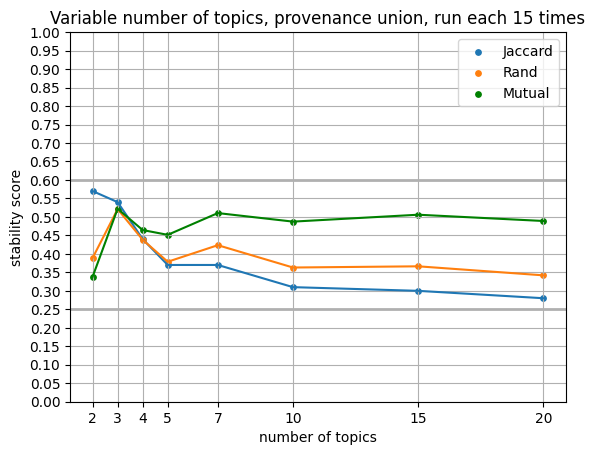

In [77]:
# Plot stability score
fig = plt.figure()
ax1 = fig.add_subplot(111)

yj = [count_jaccard(x['names'], provenance_dict) for x in list(prov_topic_dict.values())[:15]]
ax1.scatter(x=prov_topics, y=yj, s=15, c='tab:blue', marker="o", label='Jaccard')
ax1.plot(prov_topics, yj, c='tab:blue')

yr = [count_rand(x['labels']) for x in list(prov_topic_dict.values())[:15]]
ax1.scatter(x=prov_topics, y=yr, s=15, c='tab:orange', marker="o", label='Rand')
ax1.plot(prov_topics, yr, c='tab:orange')

ym = [count_mutual(x['labels']) for x in list(prov_topic_dict.values())[:15]]
ax1.scatter(x=prov_topics, y=ym, s=15, c='g', marker="o", label='Mutual')
ax1.plot(prov_topics, ym, c='g')

plt.xlabel("number of topics")
plt.xticks(prov_topics)
plt.ylabel("stability score")
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics, provenance union, run each 15 times")
plt.grid()
gridlines = ax1.get_ygridlines()
up = gridlines[12]
down = gridlines[5]
up.set_linewidth(2)
down.set_linewidth(2)

plt.legend(loc='upper right')
plt.show()

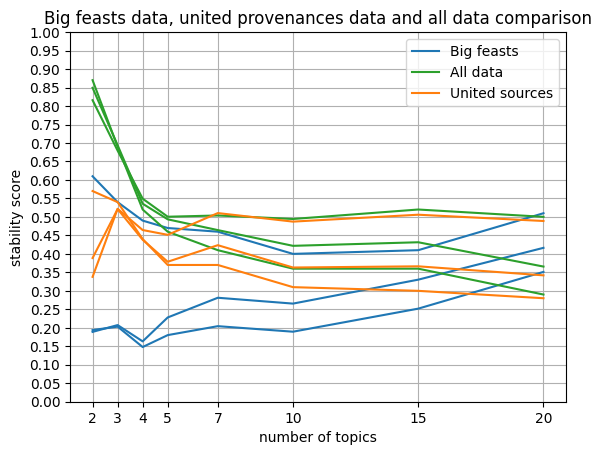

In [78]:
# Plot comparison between big_feasts, provenance_union and all data 

fig = plt.figure()
ax1 = fig.add_subplot(111)

yj = [count_jaccard(x['names'], big_f_source_dict) for x in list(dict_big_f.values())]
ax1.plot(big_f_topics, yj, c='tab:blue', label='Big feasts')

yr = [count_rand(x['labels']) for x in list(dict_big_f.values())]
ax1.plot(big_f_topics, yr, c='tab:blue')

ym = [count_mutual(x['labels']) for x in list(dict_big_f.values())]
ax1.plot(big_f_topics, ym, c='tab:blue')

used_topics_data = list(dict_all_topics.values())[:4] + [list(dict_all_topics.values())[5]] + [list(dict_all_topics.values())[8]] + [list(dict_all_topics.values())[-3]] + [list(dict_all_topics.values())[-1]]
yj = [count_jaccard(x['names'], source_dict) for x in used_topics_data]
ax1.plot(big_f_topics, yj, c='tab:green', label='All data')

yr = [count_rand(x['labels']) for x in used_topics_data]
ax1.plot(big_f_topics, yr, c='tab:green')

ym = [count_mutual(x['labels']) for x in used_topics_data]
ax1.plot(big_f_topics, ym, c='tab:green')


yj = [count_jaccard(x['names'], provenance_dict) for x in list(prov_topic_dict.values())]
ax1.plot(prov_topics, yj, c='tab:orange', label='United sources')

yr = [count_rand(x['labels']) for x in list(prov_topic_dict.values())]
ax1.plot(prov_topics, yr, c='tab:orange')

ym = [count_mutual(x['labels']) for x in list(prov_topic_dict.values())]
ax1.plot(prov_topics, ym, c='tab:orange')


plt.xlabel("number of topics")
plt.xticks(big_f_topics)
plt.ylabel("stability score")
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Big feasts data, united provenances data and all data comparison") #own complete CV
plt.grid()
plt.legend(loc='upper right')
plt.show()